<div class="alert alert-block alert-info">
<center> <h1> BUSINESS CASES WITH DATA SCIENCE </h1> </center> <br>
<center> Business Case 1: Wonderful Wines of the World </center>

**GROUP C :** <br>

- Gabriel Felipe Martins de Souza   	|   m20210598 <br>
- Rogerio Domingos Paulo	        	|   m20210597 <br>
- Luiz Humberto Polaro Vizeu		    |   m20210554 <br>
- Celso Christiano Endres Neto		    |   m20200739 <br>

**Table of Contents** <br>
* [1.0 Import](#import)
* [2.0 Data Exploration](#exploration)
* [3.0 Data Visualization](#visualization)
* [4.0 Data Preparation](#preparation)
    * [4.1 Outliers](#outliers)
* [5.0 Data Pre-Processing](#processing)
    * [5.1 Featuring Engineering](#feature)      
    * [5.2 Scaling](#scaling)  
* [6.0 Clustering](#clustering)
    * [6.1 Customer Value Clustering](#value)
    * [6.2 Customer Value & Demographic Clustering](#value_demog)
    * [6.3 Customer Behaviour Clustering](#behaviour)
    * [6.4 Merging Perspectives](#merge)
    * [6.5 Value, Demographic and Behaviour Clustering Solution](#profile)
* [7.0 RFM Analysis](#rfm)    
    * [7.1 Using RFM to Understand the Clustering Solution](#rfm_conclusion)
    

<hr>
<a class="anchor" id="import">
    
# 1.0 Import
    
</a>

In [1]:
#common packages
import pandas as pd
import numpy as np
import scipy as sp
from math import ceil, pi
import os
from itertools import product
import warnings
warnings.filterwarnings("ignore")

#dataviz
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline
sns.set()
import graphviz
import matplotlib.cm as cm

#algorithms for data preparation and preprocessing
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
from scipy import stats

#clustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.manifold import TSNE
from sklearn.base import clone
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#rfm
# !pip install squarify
import squarify


<hr>
<a class="anchor" id="exploration">
    
# 2.0 Data Exploration
    
</a>

In [2]:
df = pd.read_excel('WonderfulWinesoftheWorld.xlsx')

df.head()

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
0,5325,653,55,20,78473,20,18,826,445,7,67,4,26,2,1,1,36,5
1,3956,1041,75,18,105087,36,33,1852,539,2,49,0,46,1,3,0,20,4
2,3681,666,18,12,27984,4,56,39,-7,88,4,29,14,32,21,48,60,8
3,2829,1049,42,16,61748,2,46,37,-6,70,86,1,11,1,1,55,59,7
4,8788,837,47,16,65789,2,3,36,4,35,85,0,12,2,1,28,63,6


## Metadata
| Name     | Values         | Statistics         | Meaning                                  |
|----------|----------------|--------------------|------------------------------------------|
| CUSTID   | 1001-10000     | customer ID number |                                          |
| DAYSWUS  | 550-1250       | mean=899           | number of days as a customer             |
| AGE      | 18-78          | mean=48            | customer’s age or imputed age            |
| EDUC     | 12-20          | mean=16.7          | years of education (may be imputed)      |
| INCOME   | 10K-140K     | mean=70K          | household income (may be imputed)        |
| FREQ     | 1-56           | mean=15            | number of purchases in past 18 mo.       |
| RECENCY  | 0-550          | mean=62            | number of days since last purchase       |
| MONETARY | 6-3052       | mean=623          | total sales to this person in 18 mo.     |
| LTV      |-178 to 1791 | mean=209          | Lifetime value of the customer           |
| PERDEAL  | 0-100%         | mean=32%           | % purchases bought on discount           |
| DRYRED   | 0-100%         | mean=50%           | % of wines that were dry red wines       |
| SWEETRED | 0-100%         | mean=7%            | % sweet or semi-dry reds                 |
| DRYWH    | 0-100%         | mean=29%           | % dry white wines                        |
| SWEETWH  | 0-100%         | mean=7%            | % sweet or semi-dry white wines          |
| DESSERT  | 0-100%         | mean=7%            | % dessert wines (port, sherry, etc.)     |
| EXOTIC   | 0-100%         | mean=17%           | % very unusual wines                     |
| WEBPURCH | 0-100%         | mean=42            | % of purchases made on website           |
| WEBVISIT | 0-10           | mean=5             | average # visits to website per month    |

Features to create (Feature Engineering)
- AOV (Average order value) = MONETARY / FREQ
- AVGPERDEAL (Avg discount per purchase) = PERDEAL/FREQ
- WEBPURCHAMOUNT (total amount spent online) = WEBPURCH*MONETARY
- NONWEBPURCH (% spent in channel other than web) = 100% - WEBPURCH 
- PURCHASEPERWEBVISIT (average buys per web visit) = FREQ/WEBVISIT
- RED (%purchases of any red wine) = DRYRED+SWEETRED
- WHITE (%purchases of any white wine) = DRYWH+SWEETWH

**Note:** DRYRED + SWEETRED + DRYWH + SWEETWH + DESSERT = 100%

## Objective
Your job is to segment the database and find the relevant clusters of customers. To do this, we suggest you do 2 different segmentations, one based on engagement (or value of the customer) and a second one based on the buying behavior (or what are the types of wines they tend to buy). In the end you should provide a concatenated/joint view of the segmentation results, but also have each customer assigned to a specific cluster of engagement and a specific cluster of buying behavior. The reason for this is that we would like to understand the value of each customer but also to know what are the wines they will be more interested in buying.

## Expected outcomes
1. Explore the data and identify the variables that should be used to segment customers.
2. Identify customer segments
3. Justify the number of clusters you chose (taking in consideration the business use).
4. Explain the clusters found.
5. Suggest business applications for the findings.

In [3]:
#describes the main statistics about the dataset for categorical features
df.describe()

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6000.50000,898.102000,47.927300,16.739100,69904.358000,14.628100,62.406800,622.555200,209.07120,32.397200,50.382700,7.054500,28.521300,7.069800,6.947400,16.546600,42.376200,5.216600
std,2886.89568,202.492789,17.302721,1.876375,27612.233311,11.969073,69.874255,647.135323,291.98604,27.897094,23.453815,7.866544,12.583957,8.015083,7.879546,17.247672,18.522062,2.330457
min,1001.00000,550.000000,18.000000,12.000000,10000.000000,1.000000,0.000000,6.000000,-178.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,3500.75000,723.750000,33.000000,15.000000,47642.000000,4.000000,26.000000,63.000000,-2.00000,6.000000,32.000000,2.000000,19.000000,2.000000,2.000000,4.000000,28.000000,3.000000
50%,6000.50000,894.000000,48.000000,17.000000,70012.000000,12.000000,52.000000,383.000000,57.00000,25.000000,51.000000,4.000000,28.000000,4.000000,4.000000,10.000000,45.000000,6.000000
75%,8500.25000,1074.000000,63.000000,18.000000,92147.000000,24.000000,78.250000,1077.000000,364.00000,56.000000,69.000000,10.000000,37.000000,10.000000,9.000000,23.000000,57.000000,7.000000
max,11000.00000,1250.000000,78.000000,20.000000,140628.000000,56.000000,549.000000,3052.000000,1791.00000,97.000000,99.000000,75.000000,74.000000,62.000000,77.000000,96.000000,88.000000,10.000000


In [4]:
#show the general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Custid       10000 non-null  int64
 1   Dayswus      10000 non-null  int64
 2   Age          10000 non-null  int64
 3   Edu          10000 non-null  int64
 4   Income       10000 non-null  int64
 5   Freq         10000 non-null  int64
 6   Recency      10000 non-null  int64
 7   Monetary     10000 non-null  int64
 8   LTV          10000 non-null  int64
 9   Perdeal      10000 non-null  int64
 10  Dryred       10000 non-null  int64
 11  Sweetred     10000 non-null  int64
 12  Drywh        10000 non-null  int64
 13  Sweetwh      10000 non-null  int64
 14  Dessert      10000 non-null  int64
 15  Exotic       10000 non-null  int64
 16  WebPurchase  10000 non-null  int64
 17  WebVisit     10000 non-null  int64
dtypes: int64(18)
memory usage: 1.4 MB


In [5]:
#shows the number os null observations
df.isna().sum()

Custid         0
Dayswus        0
Age            0
Edu            0
Income         0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
dtype: int64

In [6]:
# shows duplicated observations if exists
df.duplicated().sum()

0

In [7]:
df.dtypes

Custid         int64
Dayswus        int64
Age            int64
Edu            int64
Income         int64
Freq           int64
Recency        int64
Monetary       int64
LTV            int64
Perdeal        int64
Dryred         int64
Sweetred       int64
Drywh          int64
Sweetwh        int64
Dessert        int64
Exotic         int64
WebPurchase    int64
WebVisit       int64
dtype: object

<font color='red'> 
In the initial analyzes the presence of missing values or any big problem with the data was detected. Still to better understand the aspects of the data and each variable, some data visualization methods were used as demonstrated below.

<hr>
<a class="anchor" id="visualization">
    
# 3.0 Data Visualization
    
</a>

In [8]:
df.columns

Index(['Custid', 'Dayswus', 'Age', 'Edu', 'Income', 'Freq', 'Recency',
       'Monetary', 'LTV', 'Perdeal', 'Dryred', 'Sweetred', 'Drywh', 'Sweetwh',
       'Dessert', 'Exotic', 'WebPurchase', 'WebVisit'],
      dtype='object')

In [9]:
#Defining metric and non-metric features. 
non_metric_list = ["Custid"]
metric_feat = df.columns.drop(non_metric_list).to_list()
non_metric_feat = ["Custid"]

#### Metric Features Histogram

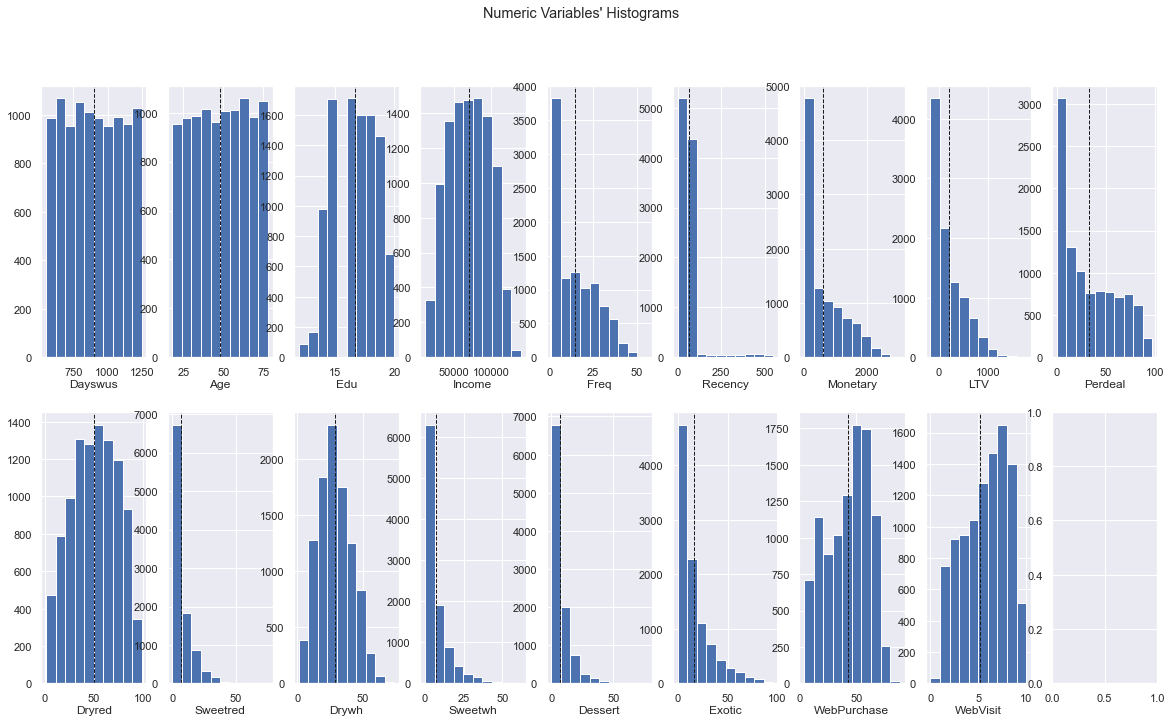

In [10]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)
    ax.axvline(df[feat].mean(), color='k', linestyle='dashed', linewidth=1)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)


plt.show()


#### Metric Features Boxplot

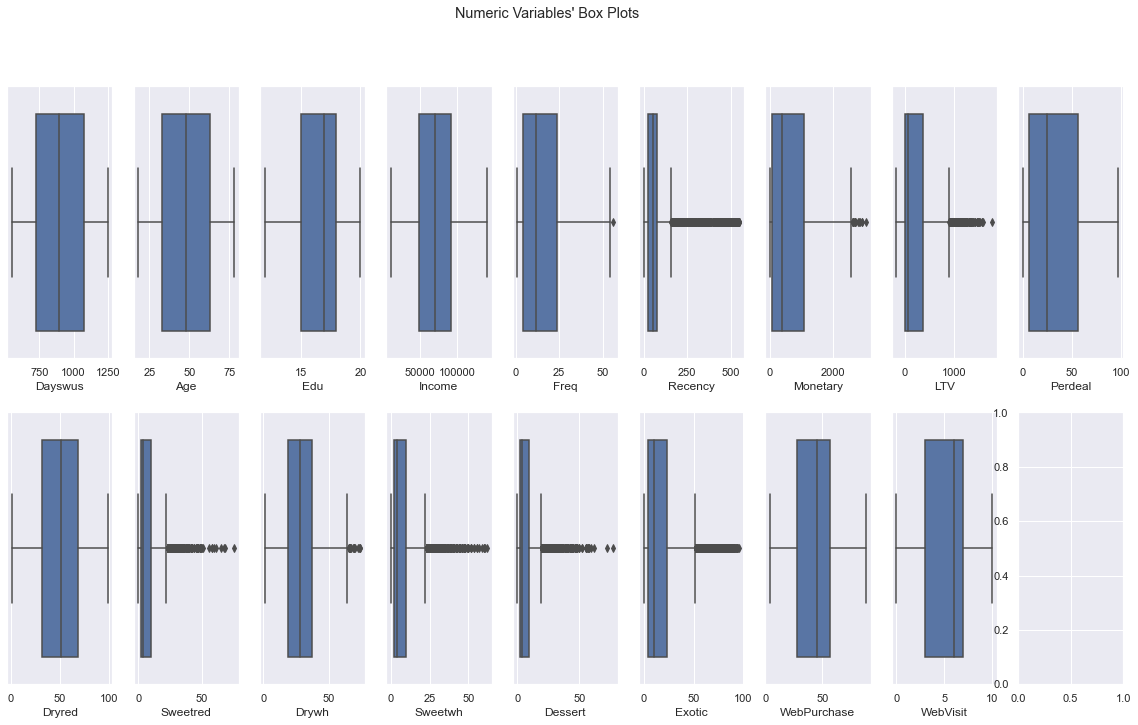

In [11]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()


<font color='red'> 
After performing some visualizations, it was possible to figure out a significant number of ouliers in important features, such as LTV, Monetary and Wines preferences. In the following steps some approaches will be tested to bring an efficient solution regarding the outliers detected.

#### Correlation Matrix (Pearson)

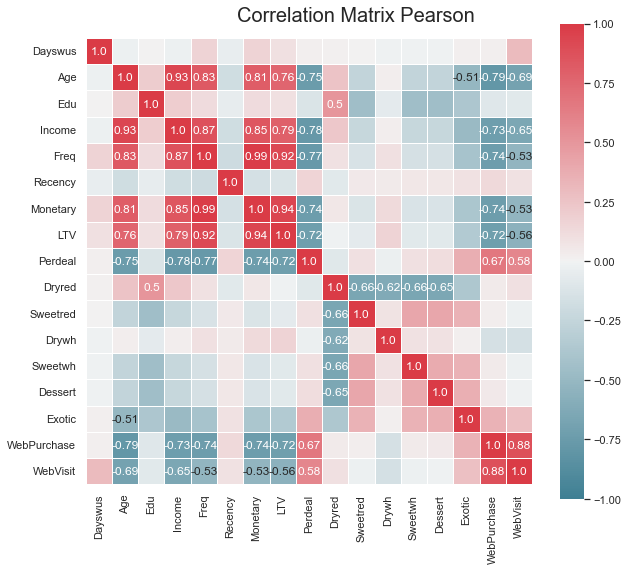

In [12]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_feat].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix Pearson", fontsize=20)

plt.show()

#### Correlation Matrix (Spearman)

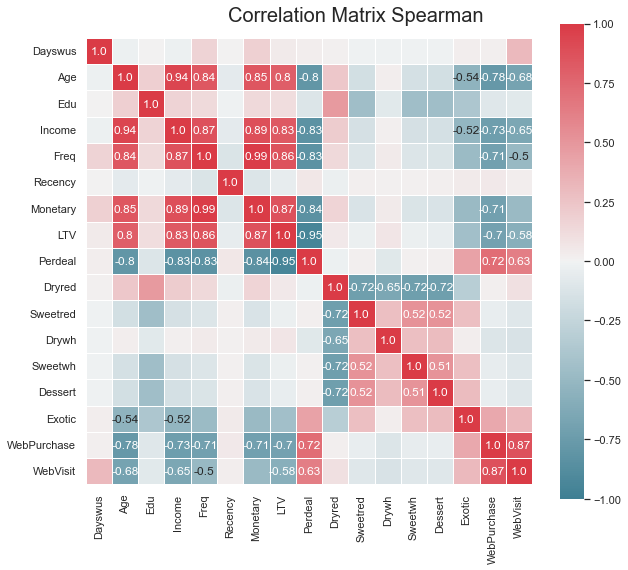

In [13]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_feat].corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix Spearman", fontsize=20)

plt.show()

- <font color='red'> By looking at the histograms, it is possible to notice that the distributions don't present high deviations, with an apparent central tendency, exception by Recency, which shows some cases way far from the average.
    
- <font color='red'> By the Boxplots it is possible confirm that the distribution of the variables is almost normal, but again, with some outliers that should be treated soon. 
     
- <font color='red'> Finally, looking at the Correlation Matrix some relationships between variables were detected, and here are some highlights:
    
    - <font color='red'> Customers who buy online have a lower purchase frequency compared to other channels;
    - <font color='red'> Perdeal has strong and positive correlation with online shopping;
    - <font color='red'> People who buy dry red wine generally do not buy other types of wine to any great extent, and the reverse is also true;
    - <font color='red'> Dry red wine has a moderate correlation with people with more years of education (Edu)
    - <font color='red'> Exotic wines are more related to older people, which is shown by the moderate negative correlation between Exotic and Age.

<hr>
<a class="anchor" id="preparation">
    
# 4.0 Data Preparation
    
</a>

<hr>
<a class="anchor" id="outliers">
    
## 4.1 Outliers
    
</a>

### Filtering by IQR method

In [14]:
#creating a copy of the dataset to test IQR outlier removal method
df_iqr = df.copy()

In [15]:
# Applying the technique IQR for outlier removal

q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 3 * iqr
lower_lim = q25 - 3 * iqr

filters = []
for metric in metric_feat:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(df_iqr[metric].between(llim, ulim, inclusive=True))

df_iqr_2 = df_iqr[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(df_iqr_2.shape[0] / df_iqr.shape[0], 4))

Percentage of data kept after removing outliers: 0.9238


<font color='red'> 
Using IQR Method we would be removing around 8% of the observations, which is not interesting for the analysis.


#### checking the box plot for the 92% of the data that were kept after IQR method (3 x iqr)

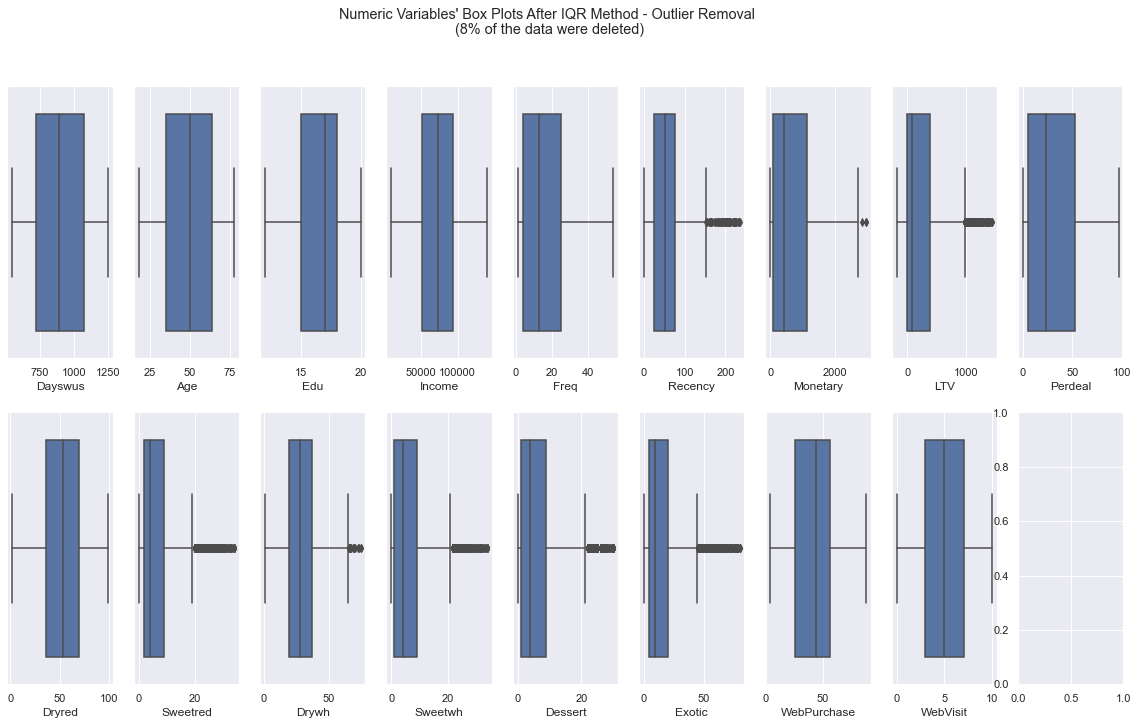

In [16]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_iqr_2[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots After IQR Method - Outlier Removal\n (8% of the data were deleted)"

plt.suptitle(title)

plt.show()


### Filtering by Z-Score method

In [17]:
#creating a copy of the dataset to test Z-Score outlier removal method
df_z = df.copy()

In [18]:
#creating an instance of the z-score for the metric features
z = np.abs(stats.zscore(df_z[metric_feat]))

# Discard the observation that are 3 standard deviations above the mean
df_z2 = df_z[(z < 3).all(axis=1)]

print('Percentage of data kept after removing outliers:', np.round(df_z2.shape[0] / df_z.shape[0], 4))

Percentage of data kept after removing outliers: 0.8923


#### checking the box plot for the 89% of the data that were kept after Z-Score method (3 std)

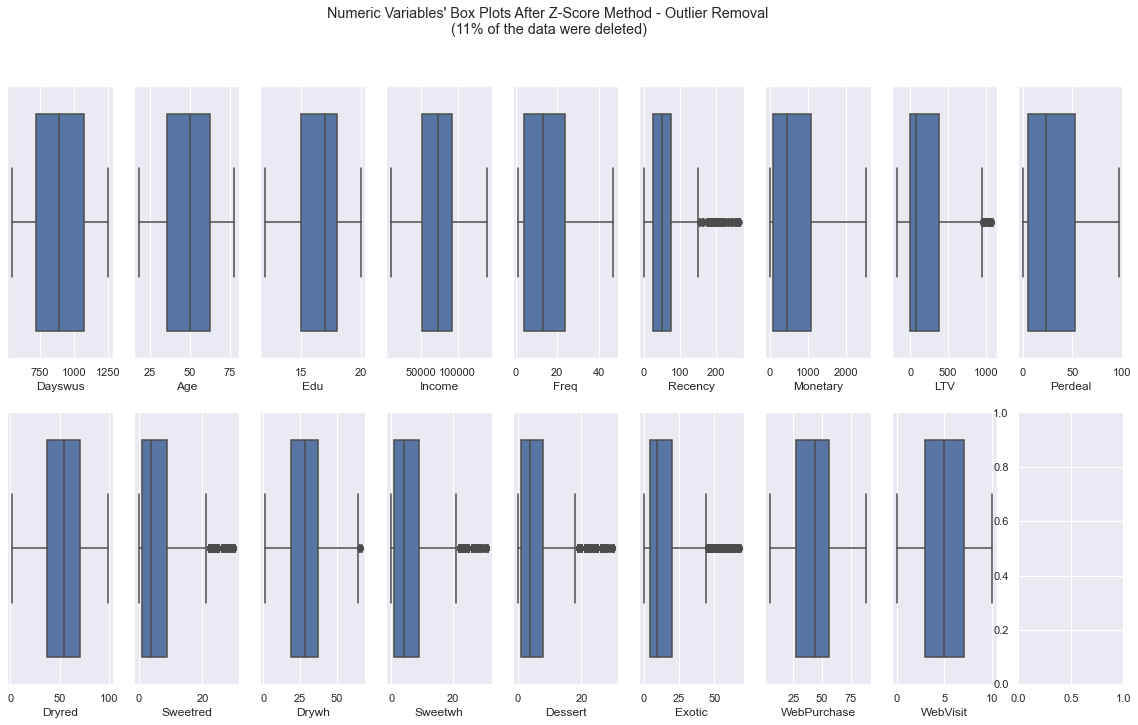

In [19]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_z2[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots After Z-Score Method - Outlier Removal\n (11% of the data were deleted)"

plt.suptitle(title)

plt.show()


### Filtering Outliers Manually

In [20]:
#creating a copy of the dataframe to filter the outliers manually
df_cleaned = df.copy()

In [21]:
#adjusting the outliers observations defining the best thresholds on each variable

df_cleaned.loc[df_cleaned['Recency'] > 450, 'Recency'] = 450

df_cleaned.loc[df_cleaned['LTV'] > 1300, 'LTV'] = 1300

df_cleaned.loc[df_cleaned['Freq'] > 50, 'Freq'] = 50

df_cleaned.loc[df_cleaned['Sweetred'] > 40, 'Sweetred'] = 40

df_cleaned.loc[df_cleaned['Dessert'] > 43, 'Dessert'] = 43

df_cleaned.loc[df_cleaned['Exotic'] > 85, 'Exotic'] = 85

print('Percentage of data kept after removing outliers:', np.round(df_cleaned.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 1.0


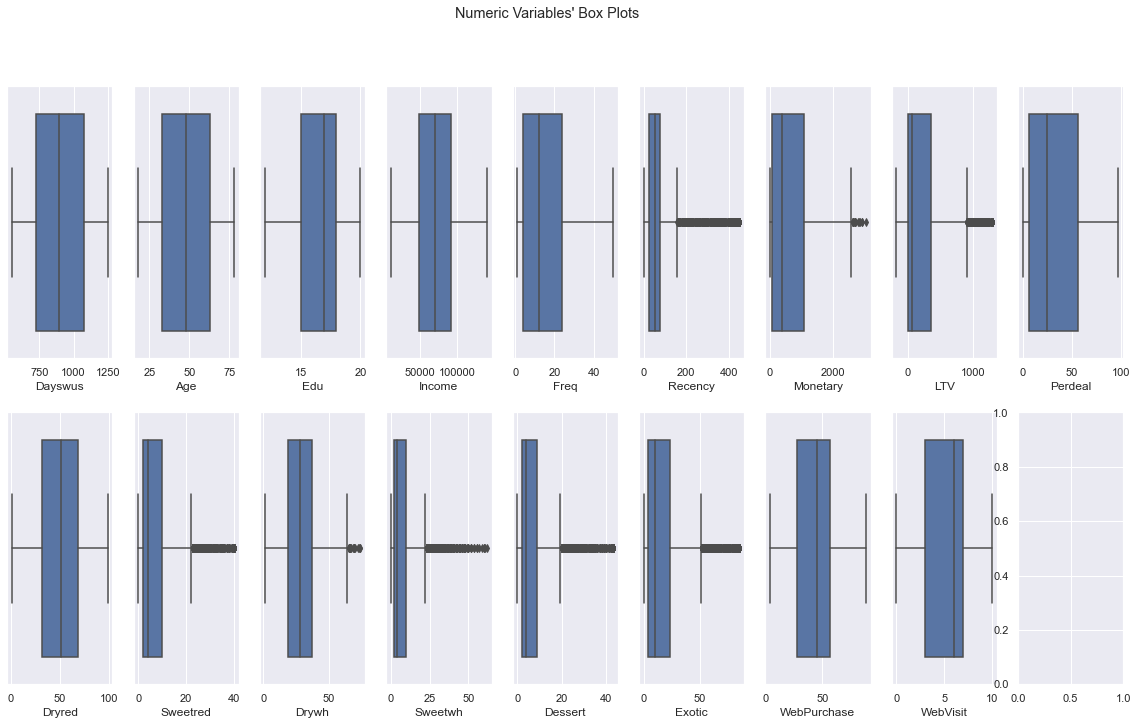

In [22]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_cleaned[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()


<font color='red'> 
After Aplplying IQR and Z-Score Method, we figure out that the amount of observations we should remove were high. Nevertheless, for the analysis purpose we should keep the most data we could. Then we decided on using a method to filter the outliers manually and to adjust the observations's threshold according to each variable and case.


<hr>
<a class="anchor" id="processing">
    
# 5.0 Data Pre-Processing
    
</a>

- Featuring Engineering
- Input Space Reduction
- Data Standardization - Scalling



<hr>
<a class="anchor" id="feature">
    
## 5.1 Feature Engineering
    
</a>

In [23]:
df = df_cleaned.copy()

In [24]:
#creating new variables from the features in the dataset
df['avg_ticket'] = df['Monetary'] / df['Freq']    #Average order value
df['Redwines'] = df['Dryred'] + df['Sweetred']   # %purchases of any red wine
df['Whitewines'] = df['Drywh'] + df['Sweetwh']   # %purchases of any white wine
df['Drywines'] = df['Drywh'] + df['Dryred']   # %purchases of any dry wine
df['Sweetwines'] = df['Sweetred'] + df['Sweetwh']   # %purchases of any sweet


#casting the variables to the right data type

df.astype({
            'avg_ticket': 'int64',
            'Redwines': 'int64',
            'Whitewines': 'int64',
            'Drywines': 'int64',
            'Sweetwines': 'int64'
          }).dtypes

Custid         int64
Dayswus        int64
Age            int64
Edu            int64
Income         int64
Freq           int64
Recency        int64
Monetary       int64
LTV            int64
Perdeal        int64
Dryred         int64
Sweetred       int64
Drywh          int64
Sweetwh        int64
Dessert        int64
Exotic         int64
WebPurchase    int64
WebVisit       int64
avg_ticket     int64
Redwines       int64
Whitewines     int64
Drywines       int64
Sweetwines     int64
dtype: object

#### Correlation Matrix - Verifying Redundancy x Relevance

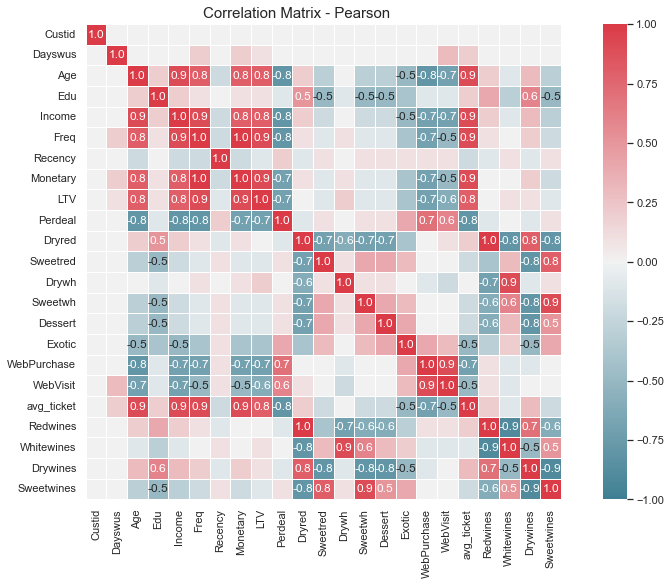

In [25]:
# Prepare figure
fig = plt.figure(figsize=(15, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df.corr(method="pearson"), decimals=1)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix - Pearson", fontsize=15)

plt.show()

<font color='red'> Redundancy Vs Relevance
- LTV, Freq, Monetary and avg_ticket are very correlated, and probably would add the same information to the model. 
- WebPurchase and WebVisit also are very correlated and we must keep only one of them to avoid redundancy.
- The wines preference seems to be very spread and when using engineered features we end up with a high redundant scenario. Afterall we will probably use only few of them in the model.


<hr>
<a class="anchor" id="scaling">
    
## 5.2 Scaling
    
</a>

In [26]:
#creating a copy to store the scaled data
df_scaled = df.copy()

df_scaled.head(2)

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,...,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit,avg_ticket,Redwines,Whitewines,Drywines,Sweetwines
0,5325,653,55,20,78473,20,18,826,445,7,...,2,1,1,36,5,41.300000,71,28,93,6
1,3956,1041,75,18,105087,36,33,1852,539,2,...,1,3,0,20,4,51.444444,49,47,95,1


### Applying StandardScaler

In [27]:
#define the metric features to be scaled
metric_features = df_scaled.columns[~df_scaled.columns.str.startswith('Custid')]

#Using StandardScaler to scale the the observations in each feature
scaler = StandardScaler()

#fits the Scaler in the metric_features
scaled_feat = scaler.fit_transform(df_scaled[metric_features])

#replacing the metric features after the scalling
df_scaled[metric_features] = scaled_feat

df_scaled.head()

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,...,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit,avg_ticket,Redwines,Whitewines,Drywines,Sweetwines
0,5325,-1.210484,0.408783,1.737959,0.310336,0.449259,-0.657000,0.314393,0.814361,-0.910434,...,-0.632564,-0.767623,-0.904125,-0.344266,-0.092948,0.682155,0.708611,-0.489263,0.764790,-0.611367
1,3956,0.705730,1.564728,0.672021,1.274232,1.786838,-0.432586,1.899921,1.138244,-1.089673,...,-0.757335,-0.508146,-0.962345,-1.208144,-0.522070,1.421843,-0.437655,0.735328,0.873301,-0.989366
2,3681,-1.146281,-1.729716,-2.525794,-1.518257,-0.888320,-0.088485,-0.901797,-0.743031,1.993239,...,3.110566,1.827143,1.832173,0.951551,1.194418,-1.618335,-1.271303,0.670876,-3.304395,3.546618
3,2829,0.745239,-0.342582,-0.393917,-0.295404,-1.055517,-0.238094,-0.904887,-0.739586,1.347978,...,-0.757335,-0.767623,2.239707,0.897558,0.765296,-0.980323,1.542259,-1.520497,0.981813,-0.913766
4,8788,-0.301764,-0.053595,-0.393917,-0.149049,-1.055517,-0.881414,-0.906433,-0.705130,0.093305,...,-0.632564,-0.767623,0.667791,1.113528,0.336174,-1.016780,1.438053,-1.391593,0.981813,-0.913766


In [28]:
# ProfileReport(
#     df_pca,
#     title='Customer Data Preprocessed',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

<hr>
<a class="anchor" id="clustering">
    
# 6.0 Clustering
    
</a>

### Defining Useful Functions to manage clustering

#### Cluster Profile Function

In [29]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
#     plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

#### K-means and Hierarchical Clustering Test Function

In [30]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

## Clustering by two Perspectives
- Customer Value
- Customer Behaviour

In [31]:
df_scaled.head(2)

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,...,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit,avg_ticket,Redwines,Whitewines,Drywines,Sweetwines
0,5325,-1.210484,0.408783,1.737959,0.310336,0.449259,-0.657000,0.314393,0.814361,-0.910434,...,-0.632564,-0.767623,-0.904125,-0.344266,-0.092948,0.682155,0.708611,-0.489263,0.764790,-0.611367
1,3956,0.705730,1.564728,0.672021,1.274232,1.786838,-0.432586,1.899921,1.138244,-1.089673,...,-0.757335,-0.508146,-0.962345,-1.208144,-0.522070,1.421843,-0.437655,0.735328,0.873301,-0.989366


#### Defining set of features for different cluster perspectives

In [32]:
# defining different features sets according to business interests
value_features = ['Dayswus','Recency','LTV','Perdeal','WebPurchase']

behaviour_features = ['Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']

demographic_features = ['Age','Edu','Income']

ValueDemographic = ['Age','Edu','Income','Dayswus','LTV','Perdeal','WebPurchase'] #excluding Recency after some tests

rfm_features = ['Recency','Freq','Monetary']

<hr>
<a class="anchor" id="value">
    
## 6.1 Customer Value Clustering
    
</a>

#### Visualizing the R² scores for the Customer Value Cluster Solutions

In [33]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_scaled[value_features], kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_scaled[value_features], hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.367506,0.148454,0.158895,0.000335,0.349151
3,0.513197,0.419608,0.176720,0.001079,0.492048
4,0.606517,0.436510,0.502170,0.001204,0.584235
5,0.668872,0.486475,0.504676,0.001871,0.633058
6,0.716655,0.555396,0.505200,0.001972,0.680942
7,0.747725,0.634317,0.560903,0.002068,0.709910
8,0.766227,0.673915,0.561924,0.002707,0.733256
9,0.779805,0.677792,0.639574,0.003262,0.749121


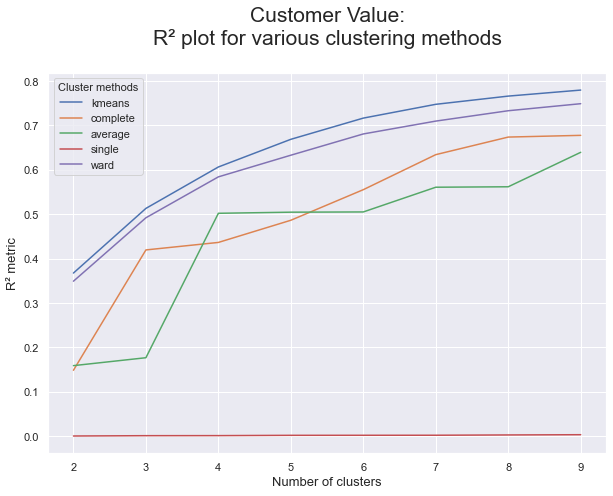

In [34]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Customer Value:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Customer Value Clustering Using K-means

#### Defining the number of clusters

In [35]:
#creating a range to iterate the number of clusters
range_clusters = range(1,11)

inertia = []

# iterate over desired ncluster range
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    # fit the clusterer
    kmclust.fit(df_scaled[value_features])
    
    # save the inertia of the given cluster solution
    inertia.append(kmclust.inertia_) 

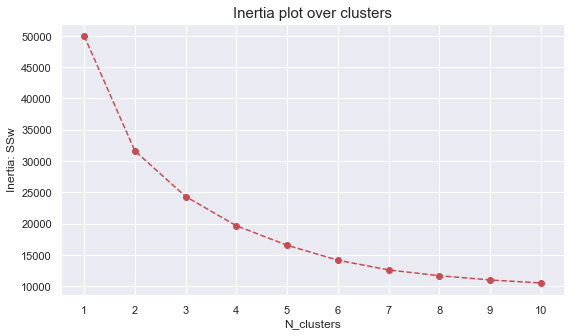

In [36]:
# Plotting the inertia to determine the number of clusters
plt.figure(figsize=(9,5))
# plt.plot(inertia)
x = range(1,11)
xi = list(range(len(x)))
y = inertia
# plot the index for the x-values
plt.plot(xi, y, marker='o', linestyle='--', color='r', label='Square')

plt.xlabel('N_clusters')
plt.ylabel('Inertia: SSw') 
plt.xticks(xi, x)
plt.title("Inertia plot over clusters", size=15)
plt.show()

#### Applying K-means for the ideal number of clusters and vefifying the clusters profile

In [37]:
# Customer Value cluster solution using K-means
number_clusters =  3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
value_labels = kmclust.fit_predict(df_scaled[value_features])
value_labels

array([2, 2, 1, ..., 1, 0, 2])

In [38]:
# Characterizing the Customer Value cluster solution
cluster_value = pd.concat((df_scaled[value_features], pd.Series(value_labels, name='value_labels')), axis=1)
cluster_value.groupby('value_labels').mean()

,Dayswus,Recency,LTV,Perdeal,WebPurchase
value_labels,,,,,
0,-0.269154,4.625456,-0.721854,0.924225,0.804724
1,-0.002268,-0.149970,-0.622806,0.568488,0.608937
2,0.027051,-0.176145,1.014976,-0.949705,-1.001044


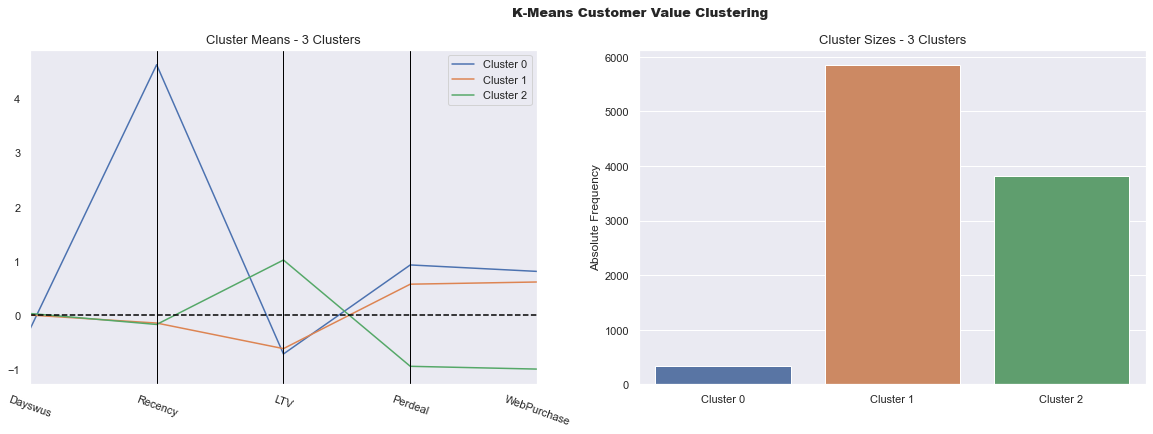

In [39]:
cluster_profiles(
    df = cluster_value, 
    label_columns = ['value_labels'], 
    figsize = (20, 6), 
    compar_titles = ["K-Means Customer Value Clustering"]
)

- <font color='red'> In Business, one of the most important unit economics is the Lifetime Value (LTV), then it was chosen as the highest important feature to build the segmentation model in terms of Customer Value. However, in the first attempt, only the features more correlated to monetary aspects have been taken into consideration, having set apart other features that could have added redundancy to the clustering model. The first solution didn't present a good separability between the clusters, besides the Recency seems to cause an interpretation distortion, since it does not have a significance correlation with LTV, as showed in the Correlation Matrix earlier. Afterwards, a new cluster solution will be performed to test better results, and for this, demographich features will be included as the Recency will be removed. The expectation is to have a model which brings more interpretability to assign marketing actions precisely.

<hr>
<a class="anchor" id="value_demog">
    
## 6.2 Customer Value and Demographic Clustering
    
</a>

#### Defining the ideal number of clusters for K-means

In [40]:
#creating a range to iterate the number of clusters
range_clusters = range(1,11)

inertia = []

# iterate over desired ncluster range
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    # fit the clusterer
    kmclust.fit(df_scaled[ValueDemographic])
    
    # save the inertia of the given cluster solution
    inertia.append(kmclust.inertia_) 

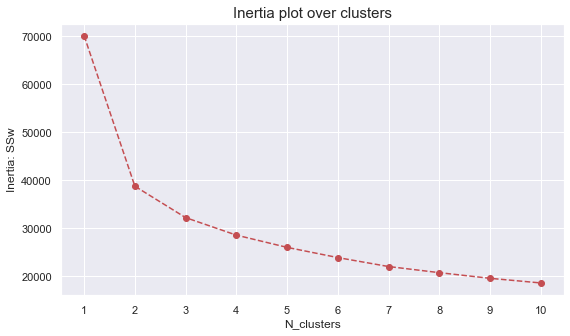

In [41]:
# Plotting the inertia to determine the number of clusters
plt.figure(figsize=(9,5))
# plt.plot(inertia)
x = range(1,11)
xi = list(range(len(x)))
y = inertia
# plot the index for the x-values
plt.plot(xi, y, marker='o', linestyle='--', color='r', label='Square')

plt.xlabel('N_clusters')
plt.ylabel('Inertia: SSw') 
plt.xticks(xi, x)
plt.title("Inertia plot over clusters", size=15)
plt.show()

#### Applying K-means for the ideal number of clusters and vefifying the clusters profile

In [42]:
# Customer Value and Demographic cluster solution using K-means
number_clusters =  3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=5)
ValueDem_labels = kmclust.fit_predict(df_scaled[ValueDemographic])
ValueDem_labels

array([2, 1, 0, ..., 0, 0, 2])

In [43]:
# Characterizing the Customer Value cluster solution
cluster_ValueDem = pd.concat((df_scaled[ValueDemographic], pd.Series(ValueDem_labels, name='ValueDem_labels')), axis=1)
cluster_ValueDem.groupby('ValueDem_labels').mean()

,Age,Edu,Income,Dayswus,LTV,Perdeal,WebPurchase
ValueDem_labels,,,,,,,
0,-0.977048,-0.246553,-0.957642,0.025927,-0.732417,0.967546,0.779556
1,1.220355,0.107736,1.207085,0.046034,1.406737,-1.048567,-1.251248
2,0.249791,0.226097,0.235896,-0.070495,-0.213405,-0.377609,0.026763


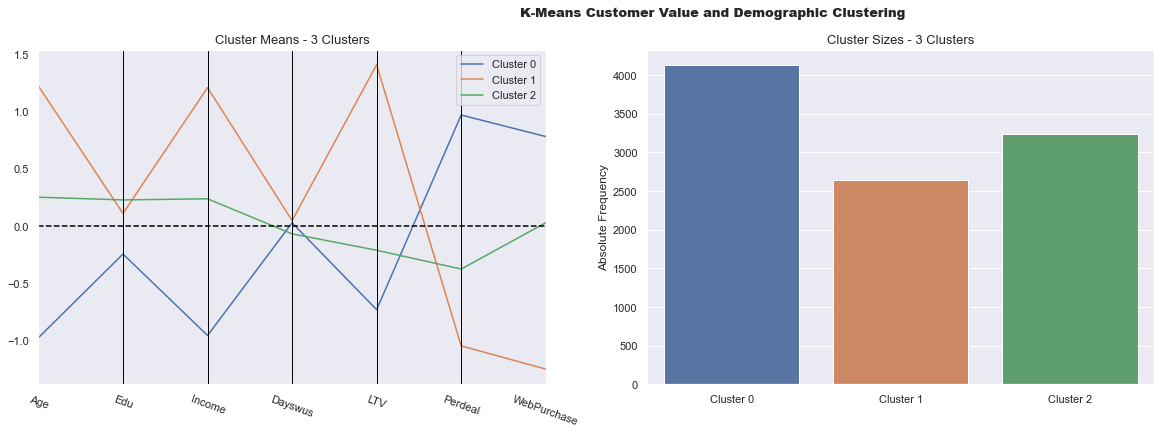

In [44]:
cluster_profiles(
    df = cluster_ValueDem, 
    label_columns = ['ValueDem_labels'], 
    figsize = (20, 6), 
    compar_titles = ["K-Means Customer Value and Demographic Clustering"]
)

<font color='red'> The k-means was applied considering only the Value & Demographic features:
- <font color='red'>Cluster 0: lowest LTV, lowest average age and Income. Has preference for online shopping and usually buys when discount is available. Represents 43%.

- <font color='red'>Cluster 1: highest value, higher average Age and Income when compared to others and most purchases are offline and without discounts. Represents 25%

- <font color='red'>Cluster 2: Average Age and Income higher than Cluster 0, but apparently the impact on its value (LTV) is more impaired due to online and discounted purchases. Represents 32%


#### Including Recency, Freq and Monetary to analyze the Customer Value and Behaviour Cluster Solution

In [45]:
df_avg = cluster_ValueDem.join(df_scaled[rfm_features])
df_avg.head(3)

,Age,Edu,Income,Dayswus,LTV,Perdeal,WebPurchase,ValueDem_labels,Recency,Freq,Monetary
0,0.408783,1.737959,0.310336,-1.210484,0.814361,-0.910434,-0.344266,2,-0.657000,0.449259,0.314393
1,1.564728,0.672021,1.274232,0.705730,1.138244,-1.089673,-1.208144,1,-0.432586,1.786838,1.899921
2,-1.729716,-2.525794,-1.518257,-1.146281,-0.743031,1.993239,0.951551,0,-0.088485,-0.888320,-0.901797


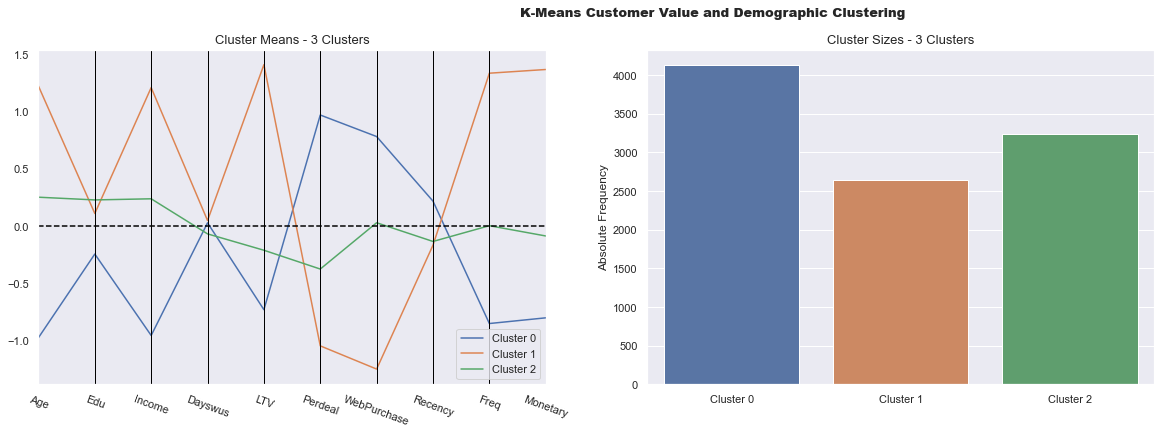

In [46]:
cluster_profiles(
    df = df_avg, 
    label_columns = ['ValueDem_labels'], 
    figsize = (20, 6), 
    compar_titles = ["K-Means Customer Value and Demographic Clustering"]
)

- <font color='red'> Adding Freq, Monetary and Recency to the table, we can see that the difference amongst the group of customers is the same. For the cluster 0, the lower LTV is also explained by the low Frequency and Monetary. In the other hand, Cluster 1, which is the most valuable, presents the higher Frequency and Monetary, and consequently its LTV is the highest compared to the other groups.

<hr>
<a class="anchor" id="behaviour">
    
## 6.3 Customer Behaviour Clustering
    
</a>

#### Visualizing the R² scores for the Customer Behaviour Cluster Solutions

In [47]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_scaled[behaviour_features], kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_scaled[behaviour_features], hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.337819,0.032329,0.027120,0.000449,0.312017
3,0.491304,0.173317,0.237616,0.001211,0.450871
4,0.538783,0.271037,0.269560,0.001563,0.490986
5,0.579959,0.285590,0.285596,0.003359,0.527445
6,0.617447,0.343228,0.298141,0.004164,0.561371
7,0.651085,0.407991,0.369608,0.005163,0.594016
8,0.674800,0.413684,0.377419,0.005665,0.618044
9,0.692368,0.588003,0.381804,0.007801,0.635362


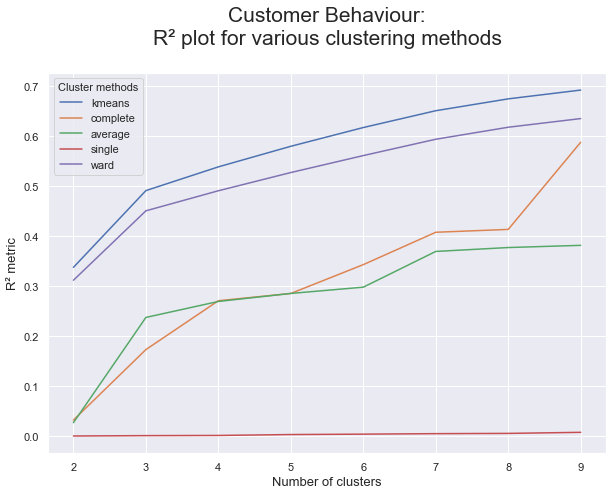

In [48]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Customer Behaviour:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Customer Behaviour Clustering Using K-means

#### Defining the number of clusters

In [49]:
#creating a range to iterate the number of clusters
range_clusters = range(1,11)

inertia = []

# iterate over desired ncluster range
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    # fit the clusterer
    kmclust.fit(df_scaled[behaviour_features])
    
    # save the inertia of the given cluster solution
    inertia.append(kmclust.inertia_) 

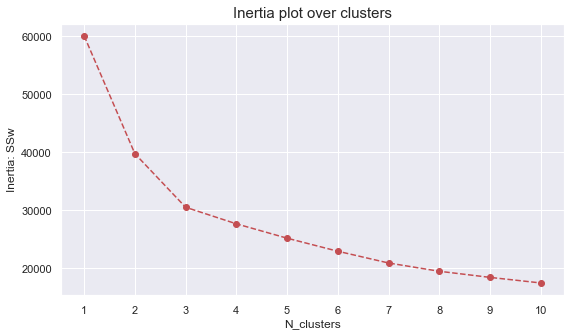

In [50]:
# Plotting the inertia to determine the number of clusters
plt.figure(figsize=(9,5))
# plt.plot(inertia)
x = range(1,11)
xi = list(range(len(x)))
y = inertia
# plot the index for the x-values
plt.plot(xi, y, marker='o', linestyle='--', color='r', label='Square')

plt.xlabel('N_clusters')
plt.ylabel('Inertia: SSw') 
plt.xticks(xi, x)
plt.title("Inertia plot over clusters", size=15)
plt.show()

#### Applying K-means for the ideal number of clusters and vefifying the clusters profile

In [51]:
# Customer Behaviour cluster solution using K-means
number_clusters =  3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
behaviour_labels = kmclust.fit_predict(df_scaled[behaviour_features])
behaviour_labels

array([2, 0, 1, ..., 1, 0, 2])

In [52]:
# Characterizing the Customer Value cluster solution
cluster_behaviour = pd.concat((df_scaled[behaviour_features], pd.Series(behaviour_labels, name='behaviour_labels')), axis=1)
cluster_behaviour.groupby('behaviour_labels').mean()

,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
behaviour_labels,,,,,,
0,-0.448753,0.009832,0.818275,0.003645,0.027475,-0.180667
1,-1.325240,1.424004,-0.137057,1.380289,1.362112,1.159720
2,0.975781,-0.580768,-0.755292,-0.557111,-0.573418,-0.286156


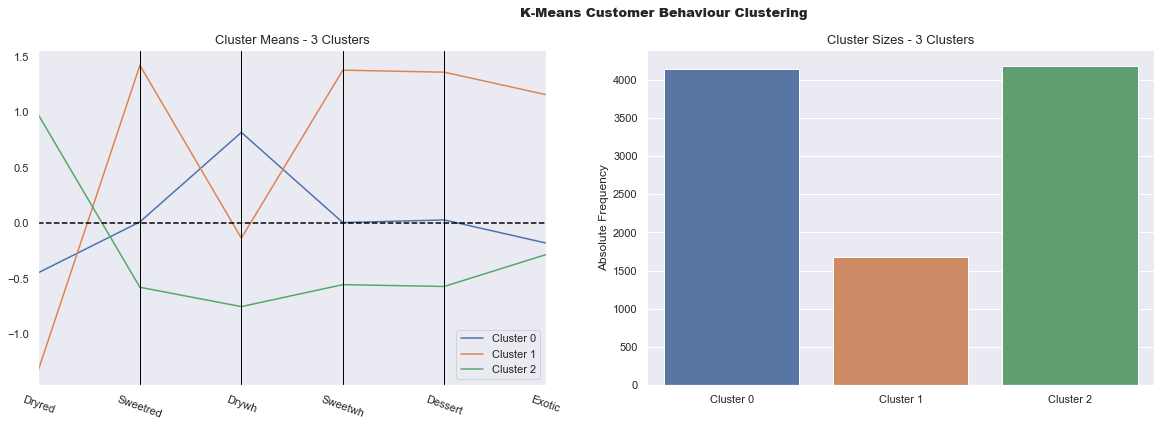

In [53]:
cluster_profiles(
    df = cluster_behaviour, 
    label_columns = ['behaviour_labels'], 
    figsize = (20, 6), 
    compar_titles = ["K-Means Customer Behaviour Clustering"]
)

- <font color='red'> The k-means was applied considering only Purchase Behavior features. 

    - <font color='red'> Cluster 0: Represents 42% of customer base. There is a preference for dry white wines.
    - <font color='red'> Cluster 1: Represents 15% of customer base. There is a preference for sweet and dessert wines as well as exotic wines.

    - <font color='red'> Cluster 2: Represents 43% of customer base. There is a preference for dry red wines.



<hr>
<a class="anchor" id="merge">
    
## 6.4 Merging Perspectives
    
</a>

In [54]:
df_to_merge = df_scaled.copy()

In [55]:
#assigning the cluster label columns into the dataframe to merge
df_to_merge['ValueDem_labels'] = cluster_ValueDem['ValueDem_labels']
df_to_merge['behaviour_labels'] = cluster_behaviour['behaviour_labels']

#verifying the size of the centroids combinations
df_to_merge.groupby(['behaviour_labels', 'ValueDem_labels']).size().to_frame()\
                .reset_index()\
                .pivot('behaviour_labels', 'ValueDem_labels', 0)


ValueDem_labels,0,1,2
behaviour_labels,,,
0,1634,1687,820
1,1264,214,199
2,1225,737,2220


In [56]:
# Centroids of the concatenated cluster labels
df_centroids = df_to_merge.groupby(['ValueDem_labels', 'behaviour_labels'])\
    [ValueDemographic+behaviour_features].mean()
df_centroids

Age       Edu    Income   Dayswus  \
ValueDem_labels behaviour_labels                                           
0               0                -0.952743 -0.060893 -0.923524  0.020626   
                1                -1.405978 -1.064345 -1.317557  0.013359   
                2                -0.566882  0.349629 -0.631777  0.045964   
1               0                 1.271082  0.049328  1.232534  0.009192   
                1                 1.179053 -0.901982  1.200501 -0.006181   
                2                 1.116231  0.534620  1.150742  0.145526   
2               0                 0.326950 -0.075436  0.276927 -0.116949   
                1                 0.219998 -0.731375  0.192928 -0.072574   
                2                 0.223962  0.423302  0.224592 -0.053150   

                                       LTV   Perdeal  WebPurchase    Dryred  \
ValueDem_labels behaviour_labels                                              
0               0                -0.723914  0.923860     0.847994 -0.479790   
                1                -0.717146  0.855553     0.785302 -1.431674   
                2                -0.759517  1.141378     0.682338  0.884882   
1               0                 1.430677 -1.064854    -1.376778 -0.512190   
                1                 1.178995 -1.064714    -1.306289 -1.163988   
                2                 1.418068 -1.006596    -0.947926  0.740657   
2               0                -0.208516 -0.445287    -0.237269 -0.256397   
                1                -0.276686 -0.501157    -0.371127 -0.822604   
                2                -0.209538 -0.341536     0.159954  1.103996   

                                  Sweetred     Drywh   Sweetwh   Dessert  \
ValueDem_labels behaviour_labels                                           
0               0                -0.026335  0.943488 -0.038413 -0.002691   
                1                 1.458198 -0.091411  1.479363  1.459996   
                2                -0.581513 -0.573716 -0.562285 -0.586201   
1               0                 0.032868  0.914570  0.021097  0.020497   
                1                 1.351347 -0.079306  1.200520  1.083876   
                2                -0.499494 -0.478892 -0.464453 -0.482797   
2               0                 0.034510  0.370654  0.051546  0.101940   
                1                 1.284942 -0.489097  0.944316  1.039586   
                2                -0.607338 -0.947245 -0.585016 -0.596450   

                                    Exotic  
ValueDem_labels behaviour_labels            
0               0                 0.218748  
                1                 1.441221  
                2                -0.021761  
1               0                -0.543353  
                1                 0.091041  
                2                -0.620060  
2               0                -0.230417  
                1                 0.520926  
                2                -0.321200

#### Using Hierarchical Clustering to Automatcally merge the cluster centroids

In [57]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

#### Hierarchical Clustering - Dendogram

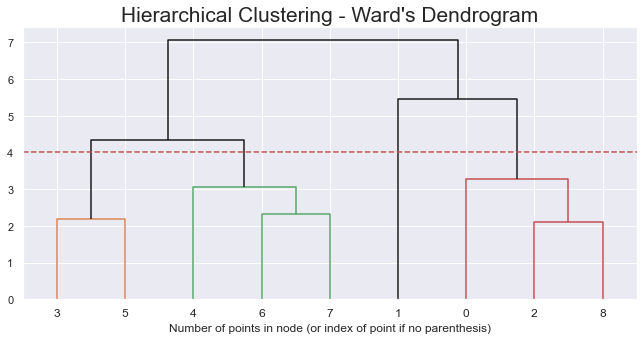

In [58]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 4
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')

plt.show()

- <font color='red'> By using the dendogram ideally the numbers of clusters could range from 2 to 4, but from a business perspective we decided on staying with 4 clusters, since we could get more interpretability to each group of customer. In the Following steps we are going to create a clustering model using Hierarchical Cluster to merge the two perspectives Behaviour and Value, and finally evaluate the results obtained. Then, we are going to check the R² too see how much of the variance is explained by the Merged Cluster slution.

#### Creating the HC model with 4 clusters to merge the previous clusters

In [59]:
# Using Hierarchical Clustering with 4 clusters to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean',
    n_clusters= 4
)
hclust_labels = hclust.fit_predict(df_centroids)

#creating the labes from hierarchical clustering in the df_centroids
df_centroids['hclust_labels'] = hclust_labels

#### Assigning the merged cluster label to the original dataframe df_to_merge

In [60]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()

# Mapping the hierarchical clusters on the centroids to the observations
df_to_merge['merged_labels'] = df_to_merge.apply(lambda row: cluster_mapper[
    (row['ValueDem_labels'], row['behaviour_labels'])
], axis=1)

# Merged cluster centroids
df_to_merge.groupby('merged_labels').mean()[ValueDemographic+behaviour_features]

,Age,Edu,Income,Dayswus,LTV,Perdeal,WebPurchase,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
merged_labels,,,,,,,,,,,,,
0,-0.345347,0.249759,-0.351323,-0.005510,-0.507670,0.423226,0.507302,0.541617,-0.414191,-0.248873,-0.403682,-0.402956,-0.075268
1,0.457580,-0.324757,0.423666,-0.090562,0.021299,-0.561812,-0.444413,-0.505302,0.464874,0.153800,0.395051,0.423697,-0.053361
2,-1.405978,-1.064345,-1.317557,0.013359,-0.717146,0.855553,0.785302,-1.431674,1.458198,-0.091411,1.479363,1.459996,1.441221
3,1.224001,0.196878,1.207666,0.050644,1.426843,-1.047141,-1.246389,-0.131271,-0.128993,0.490898,-0.126531,-0.132526,-0.566676


In [61]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_to_merge.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the value and pca labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['ValueDem_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['behaviour_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('ValueDem_labels', 'behaviour_labels', 0)

behaviour_labels,1,2
ValueDem_labels,,
0,1264.0,NaN
1,NaN,2424.0
2,1233.0,5079.0


#### Creating a function to get the R² for the merged cluster solution

In [62]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [63]:
#creating list to verify the r2 of the cluster solution
df_to_merge_r2_columns = ['Age','Edu','Income','Dayswus','LTV','Perdeal','WebPurchase', 
                  'Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic', 'merged_labels']

In [64]:
# Computing the R^2 of the cluster solution

# get total sum of squares
sst = get_ss(df_scaled[ValueDemographic+behaviour_features])  

# compute ssw for each cluster labels
ssw_labels = df_to_merge[df_to_merge_r2_columns].groupby(by='merged_labels').apply(get_ss) 

ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB

r2 = ssb / sst

print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.4132


<hr>
<a class="anchor" id="profile">
    
## 6.5 Value, Demographic and Behaviour Clustering Solution
    
</a>

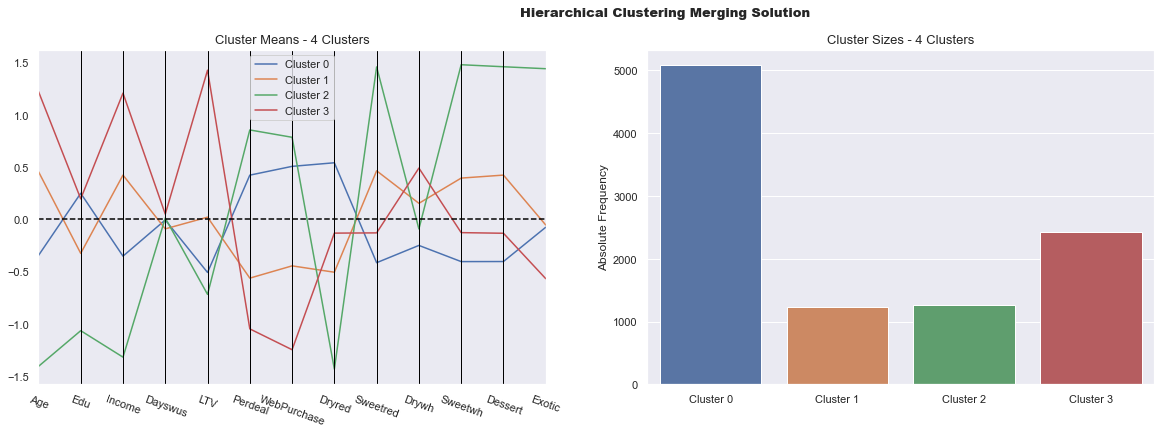

In [65]:
cluster_profiles(
    df = df_to_merge[df_to_merge_r2_columns], 
    label_columns = ['merged_labels'], 
    figsize = (20, 6), 
    compar_titles = ["Hierarchical Clustering Merging Solution"]
)

- <font color='red'> After merging the clusters using Hierarchical Clustering we figure out a 4-clusters solution, revealing a R² of 0.41, which means that this cluster solution could explain 42% of the variance in the dataset. This is the final result when we combine the Clustering Model 1, in which we applied the features related to the Value of the Customer (especially LTV) with a model 2 based on behavioral features, such as the preferences for wines.
    - Cluster 0: The largest group (Blue), with approximately 50% of the clients. Age, Income and Education are almost at the same level of the database's average. This profile of customer has a strict preference for dry red wines (Dryred) and buys the other types of wine in lower proportion. Like the Cluster 2 customers, they are heavy Web buyers, demonstrating high preference for online purchases (WebPurchase) and generally the purchases have discounts. This is the second group of customers with the worst LTV. As it represents 50% of the customers, it is extremely important to make sure that we have a specific strategy to turn these customers more profitable. To do that, we could create an exclusive offer of Dry Red selected wines only available in catalogs, or yet, available on the Website but with discounts just in the first purchase. 
    - Cluster 1: With around 12% of the customers, this profile has Age and Income above the average, and LTV exactly the average of the base (~200), which means that this group of customers is profitable. This group of client is almost eclectic, but still prefers in average more sweet wines than dry ones. As the incomes are above the average, maybe there's a chance to increase their LTV by reducing the discounts (Perdeal).
    - Cluster 2: This group represents around 13% of the customers, and so far it is the worst customers in terms of value (LTV). They have the lowest Age and Income, and are very focused in Online purchases with a high discount proportion. Still, they really are passionate for sugar, demonstrating a high preference for sweet wines, whether red or white. They are also the nº1 in Dessert and Exotic wines. 
    - Cluster 3: This group is gold! Representing 25% of the customers, this is the most valuable group in the database, as it has the highest LTV. With also the highest Age and Income average, this group of customer is almost eclectic too, except for their higher preference for Dry White wines (Drywh) and lower apetite for Exotic ones. Most of their purchases are made through the catalog and the stores, since their Web Purchase numbers are very low, still they generally never ask for discount when shopping. A good strategy is to make sure we will keep these customers in our business, then we could create a premium experience with not only exclusive catalogs, but also pyshical experiences in the stores to make these customers ambassors of the brand, and guarantee their retention.

In [66]:
#creating a copy of df original to analyze the average values of the features in the clusters
df_agg = df.copy()

#assigning the cluster label columns into the dataframe to aggregate
df_agg['merged_labels'] = df_to_merge['merged_labels']
df_agg['ValueDem_labels'] = df_to_merge['ValueDem_labels']
df_agg['behaviour_labels'] = df_to_merge['behaviour_labels']

df_agg.head()

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,...,WebPurchase,WebVisit,avg_ticket,Redwines,Whitewines,Drywines,Sweetwines,merged_labels,ValueDem_labels,behaviour_labels
0,5325,653,55,20,78473,20,18,826,445,7,...,36,5,41.300000,71,28,93,6,0,2,2
1,3956,1041,75,18,105087,36,33,1852,539,2,...,20,4,51.444444,49,47,95,1,3,1,0
2,3681,666,18,12,27984,4,56,39,-7,88,...,60,8,9.750000,33,46,18,61,2,0,1
3,2829,1049,42,16,61748,2,46,37,-6,70,...,59,7,18.500000,87,12,97,2,0,0,2
4,8788,837,47,16,65789,2,3,36,4,35,...,63,6,18.000000,85,14,97,2,0,2,2


In [67]:
# Calculate average values for each Clusters
cluster_agg = df_agg.groupby('merged_labels').agg({
    'Age' : 'mean',
    'Income': 'mean',
    'Recency': 'mean',
    'Freq': 'mean',
    'LTV': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(cluster_agg)

                Age    Income Recency  Freq    LTV Monetary      
               mean      mean    mean  mean   mean     mean count
merged_labels                                                    
0              42.0   60204.0    64.5   9.2   61.3    318.3  5079
1              55.8   81602.1    52.4  16.6  214.8    677.5  1233
2              23.6   33525.5    82.1   3.7    0.5     69.8  1264
3              69.1  103249.0    50.7  30.8  622.8   1520.4  2424


#### Using a Radar Plot for Dimensionality Visualization

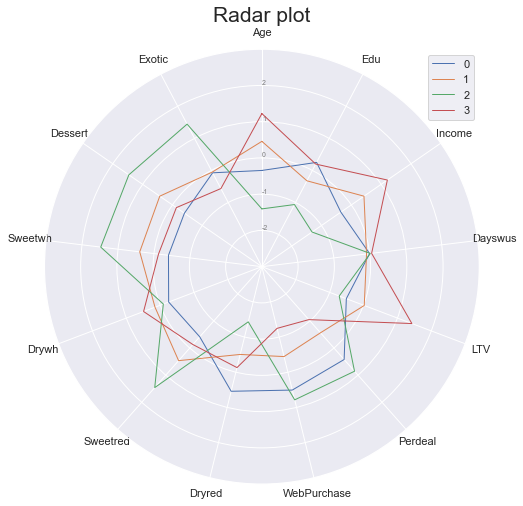

In [68]:
#creating list for the radar plot
merged_list = ['Age','Edu','Income','Dayswus','LTV','Perdeal','WebPurchase', 'Dryred',
               'Sweetred','Drywh','Sweetwh','Dessert','Exotic']

df_merge_centroids = df_to_merge.groupby('merged_labels').mean()[merged_list]

plt.figure(figsize=(15,8))
N = len(merged_list)
 
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], merged_list)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-2,-1,0,1,2], ["-2","-1","0","1","2"], color="grey", size=7)
plt.ylim(-3,3)
 
# Plot each individual 
for i in range(len(df_merge_centroids)):
    values=df_merge_centroids.loc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=i)

plt.title('Radar plot', fontsize=21)
plt.legend(loc='upper right')
plt.show()

<hr>
<a class="anchor" id="rfm">
    
# 7.0 RFM Analysis
    
</a>

#### In order to verify our solution we are going to make a RFM Analysis to evaluate the clusters obtained in the clustering process and to bring a complementary understanding of our customers.

In [69]:
#showing df_scaled for the rfm features
df_scaled[rfm_features].head(3)

,Recency,Freq,Monetary
0,-0.657000,0.449259,0.314393
1,-0.432586,1.786838,1.899921
2,-0.088485,-0.888320,-0.901797


In [70]:
#creating dataframe for RFM Clustering 
rfm_df = df_scaled[rfm_features].copy()
rfm_df.head(3)

,Recency,Freq,Monetary
0,-0.657000,0.449259,0.314393
1,-0.432586,1.786838,1.899921
2,-0.088485,-0.888320,-0.901797


In [71]:
#determining RFM quartiles
quantiles = rfm_df.quantile(q=[0.25, 0.5, 0.75])

quantiles

,Recency,Freq,Monetary
0.25,-0.537313,-0.888320,-0.864708
0.50,-0.148329,-0.219530,-0.370196
0.75,0.244396,0.783654,0.702276


In [72]:
#converting quantiles into a dictionary
quantiles = quantiles.to_dict()

quantiles

{'Recency': {0.25: -0.5373125560026516,
  0.5: -0.14832857030140248,
  0.75: 0.2443956460315894},
 'Freq': {0.25: -0.8883195717933872,
  0.5: -0.21953013321376194,
  0.75: 0.7836540246556759},
 'Monetary': {0.25: -0.8647081369876826,
  0.5: -0.3701964179721888,
  0.75: 0.7022758726426632}}

In [73]:
# Creating the RFM segmentation table
rfmSegmentation = rfm_df.copy()
rfmSegmentation.head(3)

,Recency,Freq,Monetary
0,-0.657000,0.449259,0.314393
1,-0.432586,1.786838,1.899921
2,-0.088485,-0.888320,-0.901797


#### Visualizing the Distribution of the RFM features

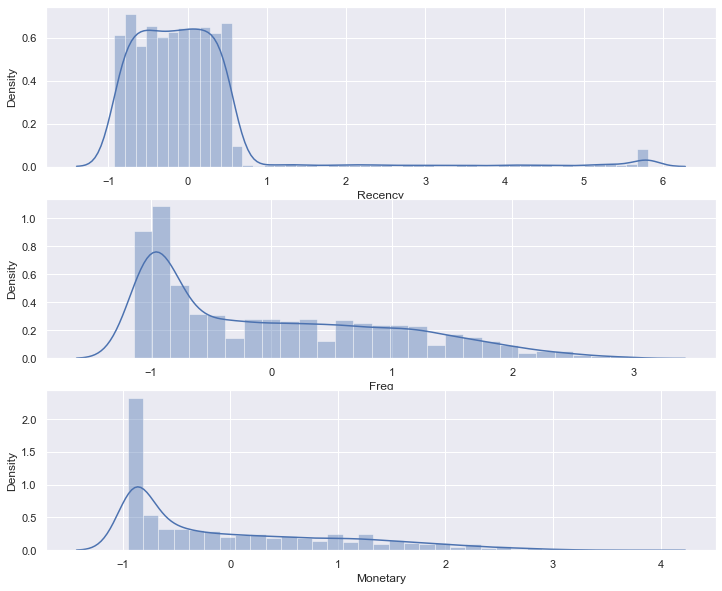

In [74]:
# Plotting RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_df['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_df['Freq'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_df['Monetary'])
# Show the plot
plt.show()

In [75]:
rfm_df.head(3)

,Recency,Freq,Monetary
0,-0.657000,0.449259,0.314393
1,-0.432586,1.786838,1.899921
2,-0.088485,-0.888320,-0.901797


#### Building the RFM Groups

In [76]:
#Calculating R, F and M groups

# Create labels for Recency and Assign these labels to 4 equal percentile groups 
r_labels = range(4, 0, -1); 
r_groups = pd.qcut(rfm_df['Recency'], q=4, labels=r_labels)

# Create labels for Frequency 
f_labels = range(1, 5)
f_groups = pd.qcut(rfm_df['Freq'], q=4, labels=f_labels)

# Create labels for Monetary
m_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(rfm_df['Monetary'], q=4, labels=m_labels)


# Create new columns R and F and M
rfm_df = rfm_df.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)


rfm_df.head(10)

,Recency,Freq,Monetary,R,F,M
0,-0.657000,0.449259,0.314393,4,3,3
1,-0.432586,1.786838,1.899921,3,4,4
2,-0.088485,-0.888320,-0.901797,2,1,1
3,-0.238094,-1.055517,-0.904887,3,1,1
4,-0.881414,-1.055517,-0.906433,4,1,1
5,-0.671961,0.198463,0.054775,4,3,3
6,-0.642039,-1.055517,-0.911069,4,1,1
7,-0.627078,1.201647,1.212241,4,4,4
8,0.360343,-1.055517,-0.929613,1,1,1
9,-0.746765,0.198463,0.043957,4,3,3


#### Concatenate the RFM quartile values to create RFM segments

In [77]:
# Concating the RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm_df['RFM_Segment_Concat'] = rfm_df.apply(join_rfm, axis=1)
rfm_df.head()

,Recency,Freq,Monetary,R,F,M,RFM_Segment_Concat
0,-0.657000,0.449259,0.314393,4,3,3,4.03.03.0
1,-0.432586,1.786838,1.899921,3,4,4,3.04.04.0
2,-0.088485,-0.888320,-0.901797,2,1,1,2.01.01.0
3,-0.238094,-1.055517,-0.904887,3,1,1,3.01.01.0
4,-0.881414,-1.055517,-0.906433,4,1,1,4.01.01.0


In [78]:
# Count num of unique segments
rfm_df_count_unique = rfm_df.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_df_count_unique.sum())

32


#### Calculate the RFM score

In [79]:
# Calculate RFM_Score
rfm_df['RFM_Score'] = rfm_df[['R','F','M']].sum(axis=1)
rfm_df.head()

,Recency,Freq,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score
0,-0.657000,0.449259,0.314393,4,3,3,4.03.03.0,10
1,-0.432586,1.786838,1.899921,3,4,4,3.04.04.0,11
2,-0.088485,-0.888320,-0.901797,2,1,1,2.01.01.0,4
3,-0.238094,-1.055517,-0.904887,3,1,1,3.01.01.0,5
4,-0.881414,-1.055517,-0.906433,4,1,1,4.01.01.0,6


#### Calculating RFM Level of each customer in the data frame rfm_df

In [80]:
# # Define rfm_df_level function
# def rfm_df_level(df):
#     if df['RFM_Score'] >= 9:
#         return 'Can\'t Loose Them'
#     elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
#         return 'Champions'
#     elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
#         return 'Loyal/Commited'
#     elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
#         return 'Potential'
#     elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
#         return 'Promising'
#     elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
#         return 'Requires Attention'
#     else:
#         return 'Demands Activation'
# # Create a new variable RFM_Level
# rfm_df['RFM_Level'] = rfm_df.apply(rfm_df_level, axis=1)
# # Printing the header with top 15 rows 
# rfm_df.head(10)

In [81]:
# Define rfm_df_level function with 4 levels
def rfm_df_level(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9)):
        return 'Silver'
    else:
        return 'Bronze'
# Create a new variable RFM_Level
rfm_df['RFM_Level'] = rfm_df.apply(rfm_df_level, axis=1)
# Printing the header with top 15 rows 
rfm_df.head(10)

,Recency,Freq,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
0,-0.657000,0.449259,0.314393,4,3,3,4.03.03.0,10,Gold
1,-0.432586,1.786838,1.899921,3,4,4,3.04.04.0,11,Gold
2,-0.088485,-0.888320,-0.901797,2,1,1,2.01.01.0,4,Bronze
3,-0.238094,-1.055517,-0.904887,3,1,1,3.01.01.0,5,Silver
4,-0.881414,-1.055517,-0.906433,4,1,1,4.01.01.0,6,Silver
5,-0.671961,0.198463,0.054775,4,3,3,4.03.03.0,10,Gold
6,-0.642039,-1.055517,-0.911069,4,1,1,4.01.01.0,6,Silver
7,-0.627078,1.201647,1.212241,4,4,4,4.04.04.0,12,Gold
8,0.360343,-1.055517,-0.929613,1,1,1,1.01.01.0,3,Bronze
9,-0.746765,0.198463,0.043957,4,3,3,4.03.03.0,10,Gold


#### Calculating the average values for each RFM_Level, and return a size of each segment

In [90]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_df.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Freq': 'mean',
    'RFM_Score': 'mean',
    'Monetary': ['mean', 'count']
    
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

          Recency Freq RFM_Score Monetary      
             mean mean      mean     mean count
RFM_Level                                      
Bronze        1.3 -1.0       3.4     -0.9  1513
Gold         -0.3  1.1      10.2      1.0  3720
Silver       -0.2 -0.5       6.5     -0.5  4767


#### Plotting the RFM level on the Squarify (library)

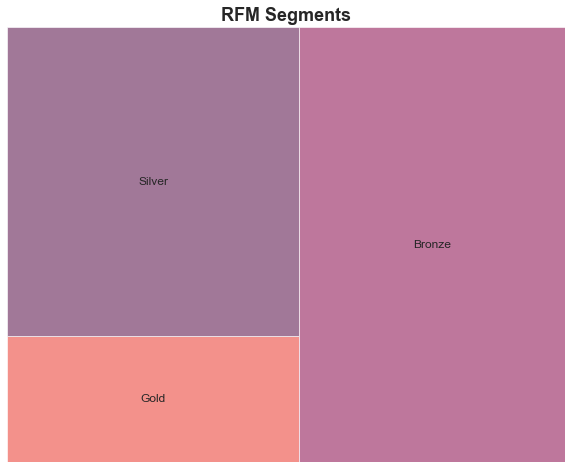

In [83]:
rfm_level_agg.columns = ['RecencyMean','FreqMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 8)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Gold',
                     'Silver',
                     'Bronze'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [84]:
#Creating a copy of df merged to analyze RFM Level profile
df_to_merge_rfm = df_to_merge.copy()
#inserting RFM_level column to the df
df_to_merge_rfm['RFM_Level'] = rfm_df['RFM_Level']

In [85]:
#creating features list to analyze the RFM Levels
rfm_features_all = ['Age','Edu','Income','Dayswus','LTV','Perdeal','WebPurchase','Recency','Freq','Monetary','RFM_Level']

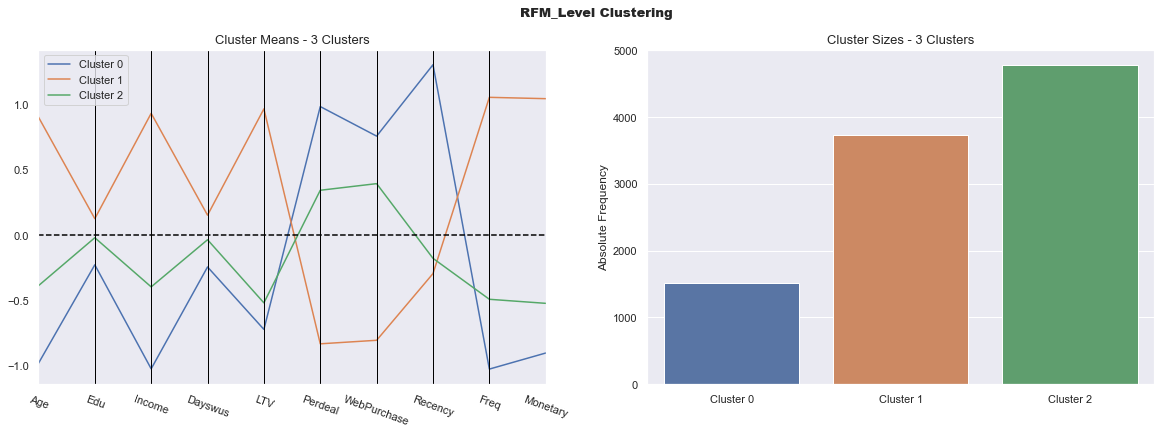

In [86]:
cluster_profiles(
    df = df_to_merge_rfm[rfm_features_all], 
    label_columns = ['RFM_Level'], 
    figsize = (20, 6), 
    compar_titles = ["RFM_Level Clustering"]
)

<hr>
<a class="anchor" id="rfm_conclusion">
    
## 7.1 Using RFM Analysis to Understand the Clustering Solution
    
</a>

In [87]:
df_to_merge_rfm.head(2)

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,...,WebVisit,avg_ticket,Redwines,Whitewines,Drywines,Sweetwines,ValueDem_labels,behaviour_labels,merged_labels,RFM_Level
0,5325,-1.210484,0.408783,1.737959,0.310336,0.449259,-0.657000,0.314393,0.814361,-0.910434,...,-0.092948,0.682155,0.708611,-0.489263,0.764790,-0.611367,2,2,0,Gold
1,3956,0.705730,1.564728,0.672021,1.274232,1.786838,-0.432586,1.899921,1.138244,-1.089673,...,-0.522070,1.421843,-0.437655,0.735328,0.873301,-0.989366,1,0,3,Gold


In [91]:
#creating a copy of df original to analyze the average values of the features in the RFM and Cluster
df_rfm_agg = df.copy()

#assigning the cluster label columns into the dataframe to aggregate
df_rfm_agg['RFM_Level'] = df_to_merge_rfm['RFM_Level']
df_rfm_agg['merged_labels'] = df_to_merge_rfm['merged_labels']


df_rfm_agg.head()

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,...,Exotic,WebPurchase,WebVisit,avg_ticket,Redwines,Whitewines,Drywines,Sweetwines,RFM_Level,merged_labels
0,5325,653,55,20,78473,20,18,826,445,7,...,1,36,5,41.300000,71,28,93,6,Gold,0
1,3956,1041,75,18,105087,36,33,1852,539,2,...,0,20,4,51.444444,49,47,95,1,Gold,3
2,3681,666,18,12,27984,4,56,39,-7,88,...,48,60,8,9.750000,33,46,18,61,Bronze,2
3,2829,1049,42,16,61748,2,46,37,-6,70,...,55,59,7,18.500000,87,12,97,2,Silver,0
4,8788,837,47,16,65789,2,3,36,4,35,...,28,63,6,18.000000,85,14,97,2,Silver,0


In [93]:
# Calculate average values for each RFM_Level, and return a size of each segment 
cluster_rfm_agg = df_rfm_agg.groupby(['RFM_Level']).agg({
    'Custid': 'count',
    'Recency': 'mean',
    'Freq': 'mean',
    'Monetary': 'mean',
    'LTV': 'mean'
    
}).round(1)
# Print the aggregated dataset
print(cluster_rfm_agg)

           Custid  Recency  Freq  Monetary    LTV
RFM_Level                                        
Bronze       1513    149.1   2.3      35.4   -2.1
Gold         3720     42.0  27.2    1297.8  488.7
Silver       4767     49.8   8.7     282.0   57.0


In [98]:
df[['Recency','Freq','Monetary','LTV']].describe()

,Recency,Freq,Monetary,LTV
count,10000.00000,10000.00000,10000.000000,10000.000000
mean,61.91440,14.62600,622.555200,208.649000
std,66.84414,11.96251,647.135323,290.243216
min,0.00000,1.00000,6.000000,-178.000000
25%,26.00000,4.00000,63.000000,-2.000000
50%,52.00000,12.00000,383.000000,57.000000
75%,78.25000,24.00000,1077.000000,364.000000
max,450.00000,50.00000,3052.000000,1300.000000


From the RFM Level segmentation we can describe the groups as following:
- GOLD: Around 37% of the customers, most valuable group in terms of LTV (average LTV of 488). These customers have the highest average frequency (27.2) twice the average of the base, they return to shopping every 42 days (50% less time compared to the average), and finally, they spend 2 times more money than the average, 6x more than the Silver and around 37x more compared to the Bronze Customers.
- SILVER: 47% of the customers lies on this group. In average this group is still profitable, but its LTV of 57.0 is below the average (which is ~208). These customers also return to shopping in less days compared to the average (49.8 versus 61.9), but both its Frequency and Monetary are lower than the average, at least 1.6X and 2.2X, respectively.
- BRONZE: 15% of the clients, this group is the worst in terms of LTV (-2.1), which means that these customers at the end of the day cause losses to the business. With a Frequency ~7 times lower than the average and the Monetary in average 17 times below the overall average, these customers probably need to be reactivate, since their Recency is around 150 days.


#### RFM & Clustering Aggregation

In [89]:
# Calculate average values for each RFM_Level, and return a size of each segment 
cluster_rfm_agg = df_rfm_agg.groupby(['merged_labels','RFM_Level']).agg({
    'Custid': 'count',
    'Recency': 'mean',
    'Freq': 'mean',
    'Monetary': 'mean',
    'LTV': 'mean'
    
}).round(1)
# Print the aggregated dataset
print(cluster_rfm_agg)

                         Custid  Recency  Freq  Monetary    LTV
merged_labels RFM_Level                                        
0             Bronze        962    148.0   2.3      36.7   -2.9
              Gold          912     30.1  19.6     820.4  207.0
              Silver       3205     49.3   8.3     259.9   39.1
1             Bronze         51    131.3   2.4      47.9    8.4
              Gold          559     35.6  22.4     991.5  334.6
              Silver        623     60.9  12.5     447.3  124.2
2             Bronze        500    152.8   2.3      31.7   -1.6
              Gold           13     29.1  14.2     502.8   44.1
              Silver        751     36.0   4.4      87.6    1.2
3             Gold         2236     48.5  31.6    1573.6  644.8
              Silver        188     77.2  20.9     887.4  361.1


### Thanks!